**<h1  align="center"><center>Food Chain Sentimental Analysis</h1>**


#### **<font color = "black" size = "5">1. Generating Feedback Sample Dataset</font>**

In [1]:
import csv
import random
from datetime import datetime, timedelta

# Feedback templates with placeholders
feedback_templates = [
    "The {aspect} was {adjective}, really made my day!",
    "I felt that the {aspect} could be more {adjective}.",
    "The staff were {behavior}, which {effect}.",
    "Having {feature} is great, it {benefit}.",
    "{dish} was {adjective}, just like you'd expect at a good restaurant.",
    "The atmosphere is {adjective}, it {effect} when you dine.",
    "I found the {aspect} to be {adjective}, which is {evaluation}.",
    "A bit disappointed with the {aspect}, was expecting something more {adjective}.",
    "It's {adjective} how the restaurant manages to {achievement}.",
    "{aspect} was top-notch, {compliment}.",
    # Add more templates as needed
]

# Words to fill the placeholders
aspects = ['service', 'food quality', 'ambience', 'price', 'menu variety']
adjectives = ['amazing', 'disappointing', 'excellent', 'mediocre', 'impressive', 'lacking']
behaviors = ['helpful and courteous', 'indifferent', 'rude', 'welcoming']
effects = ['enhances the dining experience', 'puts a damper on the meal', 'leaves a lot to be desired']
features = ['an online reservation system', 'valet parking', 'live music', 'outdoor seating']
benefits = ['adds a lot of convenience', 'makes me want to come back', 'is a unique touch']
dishes = ['The seafood platter', 'The vegan burger', 'The homemade pasta', 'The rib-eye steak']
evaluations = ['commendable', 'something I value', 'disappointing to see', 'worth mentioning']
achievements = ['keep such high standards', 'offer a diverse menu', 'retain a loyal clientele']
compliments = ['I will be coming back again', 'I would recommend to my friends', 'that deserves praise']

# Function to generate random dates
def generate_random_date():
    start_date = datetime(2021, 1, 1)
    end_date = datetime(2023, 1, 1)
    time_between_dates = end_date - start_date
    random_number_of_days = random.randrange(time_between_dates.days)
    random_date = start_date + timedelta(days=random_number_of_days)
    return random_date.strftime("%Y-%m-%d")


# Function to generate a single feedback string
def generate_feedback():
    template = random.choice(feedback_templates)
    feedback = template.format(
        aspect=random.choice(aspects),
        adjective=random.choice(adjectives),
        behavior=random.choice(behaviors),
        effect=random.choice(effects),
        feature=random.choice(features),
        benefit=random.choice(benefits),
        dish=random.choice(dishes),
        evaluation=random.choice(evaluations),
        achievement=random.choice(achievements),
        compliment=random.choice(compliments)
    )
    return feedback


# Function to generate feedback data including additional fields
def generate_feedback_data(num_records):
    feedback_data = []
    for i in range(num_records):
        restaurant_number = f"{random.randint(100, 999)}-{random.randint(1000, 9999)}"
        location = f"{random.choice(['Toronto', 'Vancouver', 'Montreal', 'Calgary', 'Barrie', 'Mississauga', 'Hamilton', 'North York', 'Markham', 'Richmond Hill'])}, Canada"
        feedback = generate_feedback()
        date_posted = generate_random_date()
        feedback_data.append({
            'restaurant_number': restaurant_number,
            'location': location,
            'feedback': feedback,
            'date_posted': date_posted
        })
    return feedback_data

# Function to write the dataset to a CSV file
def write_to_csv(file_name, data):
    with open(file_name, mode='w', newline='', encoding='utf-8') as file:
        fieldnames = ['restaurant_number', 'location', 'feedback', 'date_posted']
        writer = csv.DictWriter(file, fieldnames=fieldnames)
        writer.writeheader()
        for item in data:
            writer.writerow(item)


# Main function to generate feedback dataset and write to CSV
def main():
    num_records = 1000
    file_name = 'feedback_data.csv'
    feedback_dataset = generate_feedback_data(num_records)  # Use the correct function here
    write_to_csv(file_name, feedback_dataset)
    print(f"{num_records} feedback records have been written to {file_name}")

# Run the main function
if __name__ == "__main__":
    main()

1000 feedback records have been written to feedback_data.csv


#### **<font color = "black" size = "5">2. Adding Sentiment and Confidence attributes LLM (Huggingface model) </font>**

In [3]:
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 44.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 31.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 81.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 70.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 21.6 MB/s eta 0:00:00


In [4]:
from transformers import pipeline
import pandas as pd
import numpy as np
from joblib import Parallel, delayed
import multiprocessing
import warnings

# Ignore the specific UserWarning related to resource_tracker
warnings.filterwarnings("ignore", category=UserWarning, message="resource_tracker: There appear to be")



# Function to initialize the classifier inside the parallel process
def init_classifier():
    return pipeline('sentiment-analysis', model="distilbert-base-uncased-finetuned-sst-2-english")

# Function to analyze sentiment in batches and return labels and scores
def analyze_sentiment_in_batches(classifier, texts, batch_size=32):
    results = classifier(texts, batch_size=batch_size)
    labels = [result['label'] for result in results]
    scores = [result['score'] for result in results]
    return labels, scores

# Function to process a slice of the DataFrame
def process_slice(df_slice, batch_size):
    classifier = init_classifier()
    texts = df_slice['feedback'].tolist()
    labels, scores = analyze_sentiment_in_batches(classifier, texts, batch_size)
    return labels, scores

df = pd.read_csv('feedback_data.csv')

n_cores = multiprocessing.cpu_count() - 1  # Leave one core free for other operations

# Adjust the batch size according to your system's capabilities
batch_size = 16  # You may need to reduce this if you encounter memory issues

# Ensure not to exceed the number of chunks over the number of data rows
n_chunks = min(len(df), n_cores)

chunks = np.array_split(df, n_chunks)
results = Parallel(n_jobs=n_chunks)(delayed(process_slice)(chunk, batch_size) for chunk in chunks)

labels, scores = zip(*results)
df['Sentiment'] = [label for sublist in labels for label in sublist]
df['Confidence'] = [score for sublist in scores for score in sublist]

df.to_csv('feedback_data_with_sentiment.csv', index=False)

print("Sentiment analysis completed and saved to feedback_data_with_sentiment.csv")


Sentiment analysis completed and saved to feedback_data_with_sentiment.csv


#### **<font color = "black" size = "5">3. Data Cleaning and Preprocessing </font>**

#### **<font color = "black" size = "3">*Check NA or missing values* </font>**

In [8]:
missing_values = df.isnull().sum()
missing_values

restaurant_number    0
location             0
feedback             0
date_posted          0
Sentiment            0
Confidence           0
dtype: int64

#### **<font color = "black" size = "3">*Correct Data Types* </font>**

In [9]:
df['date_posted'] = pd.to_datetime(df['date_posted'])
df['Sentiment'] = df['Sentiment'].astype('category')

#### **<font color = "black" size = "3">*Remove Duplicates* </font>**

In [10]:
df = df.drop_duplicates()

#### **<font color = "black" size = "3">*Create New Features* </font>**

In [12]:
# Step 4: Feature Engineering - Extract Year, Month, and Day from date_posted
df['year'] = df['date_posted'].dt.year
df['month'] = df['date_posted'].dt.month
df['day'] = df['date_posted'].dt.day

df.head()

,restaurant_number,location,feedback,date_posted,Sentiment,Confidence,year,month,day
0,461-2815,"North York, Canada","A bit disappointed with the service, was expec...",2021-04-05,NEGATIVE,0.970257,2021,4,5
1,162-1203,"Richmond Hill, Canada",I felt that the menu variety could be more exc...,2022-02-06,NEGATIVE,0.973279,2022,2,6
2,274-8441,"Montreal, Canada",I felt that the price could be more lacking.,2021-01-22,NEGATIVE,0.998149,2021,1,22
3,327-7081,"Vancouver, Canada","A bit disappointed with the price, was expecti...",2021-04-07,NEGATIVE,0.999660,2021,4,7
4,168-9719,"Markham, Canada","The rib-eye steak was mediocre, just like you'...",2022-09-11,NEGATIVE,0.986287,2022,9,11


In [13]:
# Check the dataframe and missing values
df.info(), missing_values

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 0 to 999
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   restaurant_number  1000 non-null   object        
 1   location           1000 non-null   object        
 2   feedback           1000 non-null   object        
 3   date_posted        1000 non-null   datetime64[ns]
 4   Sentiment          1000 non-null   category      
 5   Confidence         1000 non-null   float64       
 6   year               1000 non-null   int64         
 7   month              1000 non-null   int64         
 8   day                1000 non-null   int64         
dtypes: category(1), datetime64[ns](1), float64(1), int64(3), object(3)
memory usage: 71.4+ KB


(None,
 restaurant_number    0
 location             0
 feedback             0
 date_posted          0
 Sentiment            0
 Confidence           0
 dtype: int64)

#### **<font color = "black" size = "5">4. Exploratory Data Analysis (EDA) </font>**

In [18]:
# EDA Step 1: Summary Statistics for the 'Confidence' numerical column
confidence_summary = df['Confidence'].describe()
confidence_summary

count    1000.000000
mean        0.988567
std         0.043799
min         0.545203
25%         0.997293
50%         0.999663
75%         0.999840
max         0.999888
Name: Confidence, dtype: float64

In [19]:
# EDA Step 2: Examine the distribution of sentiments
sentiment_distribution = df['Sentiment'].value_counts()
sentiment_distribution

POSITIVE    557
NEGATIVE    443
Name: Sentiment, dtype: int64

In [20]:
# EDA Step 3: Confidence Level Analysis
confidence_by_sentiment = df.groupby('Sentiment')['Confidence'].describe()
confidence_by_sentiment

,count,mean,std,min,25%,50%,75%,max
Sentiment,,,,,,,,
NEGATIVE,443.0,0.985109,0.040536,0.681398,0.988479,0.998856,0.999674,0.999811
POSITIVE,557.0,0.991317,0.046081,0.545203,0.999171,0.999808,0.999865,0.999888


#### **<font color = "black" size = "5">5. Visualizations </font>**

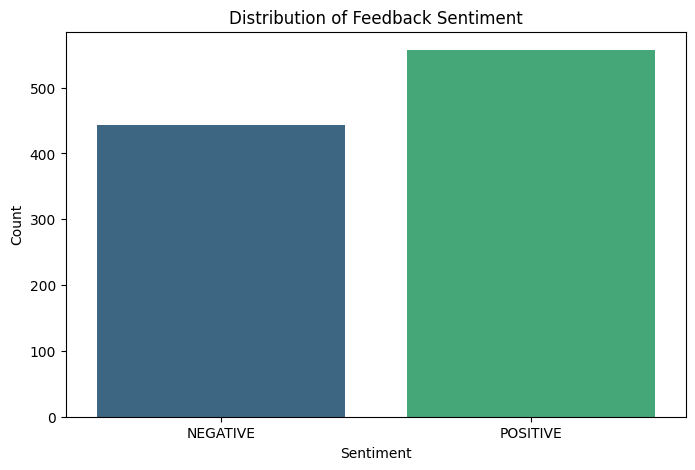

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
# Visualization Step 1: Sentiment Count Plot
plt.figure(figsize=(8, 5))
sns.countplot(data=df, x='Sentiment', palette='viridis')
plt.title('Distribution of Feedback Sentiment')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

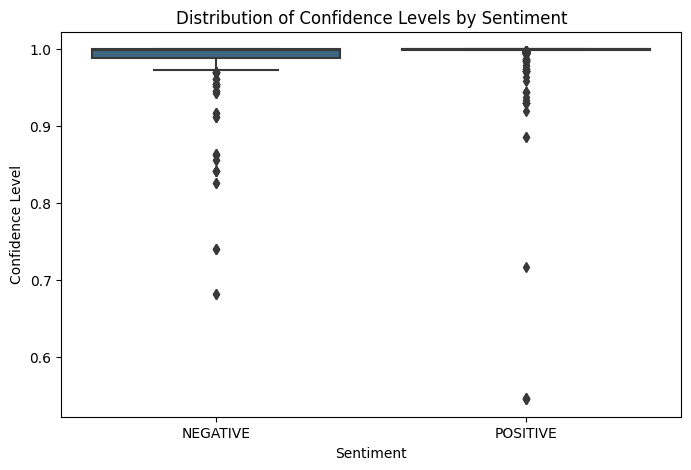

In [24]:
# Visualization Step 2: Confidence Distribution Plot
plt.figure(figsize=(8, 5))
sns.boxplot(data=df, x='Sentiment', y='Confidence', palette='viridis')
plt.title('Distribution of Confidence Levels by Sentiment')
plt.xlabel('Sentiment')
plt.ylabel('Confidence Level')
plt.show()

<Figure size 1400x700 with 0 Axes>

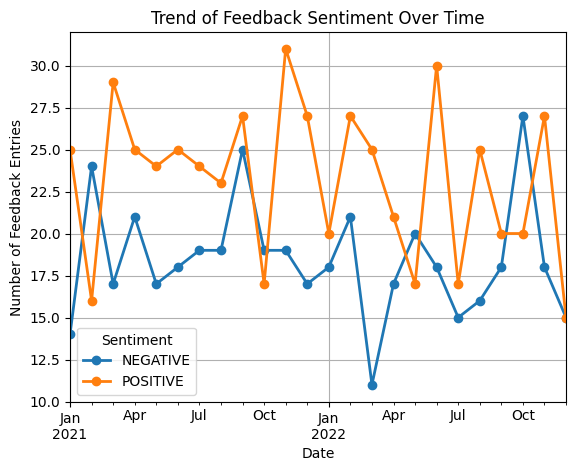

In [25]:
# Visualization Step 3: Time Series Plot of Sentiment Over Time

# We'll first create a DataFrame that counts the number of positive and negative feedbacks per month
feedback_sentiment_over_time = df.groupby(['year', 'month', 'Sentiment']).size().unstack(fill_value=0)

# Since we have year and month as separate columns, we need to convert them back to datetime to plot
feedback_sentiment_over_time.index = pd.to_datetime(feedback_sentiment_over_time.index.map(lambda x: f"{x[0]}-{x[1]}"))

# Plotting the trend of positive and negative feedback over time
plt.figure(figsize=(14, 7))
feedback_sentiment_over_time.plot(kind='line', marker='o', linestyle='-', linewidth=2)
plt.title('Trend of Feedback Sentiment Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Feedback Entries')
plt.legend(title='Sentiment')
plt.grid(True)
plt.show()

#### **<font color = "black" size = "5">6. Advanced Analysis </font>**

### ***Chi Square Test***

In [26]:
from scipy.stats import chi2_contingency

# Create a contingency table for the chi-square test
contingency_table = pd.crosstab(df['month'], df['Sentiment'])

# Perform the chi-square test
chi2, p, dof, expected = chi2_contingency(contingency_table)

chi2_test_results = {
    'Chi-Square Statistic': chi2,
    'p-value': p,
    'Degrees of Freedom': dof,
    'Expected Frequencies': expected
}

chi2_test_results

{'Chi-Square Statistic': 12.42025770082138,
 'p-value': 0.33289655750150904,
 'Degrees of Freedom': 11,
 'Expected Frequencies': array([[34.111, 42.889],
        [38.984, 49.016],
        [36.326, 45.674],
        [37.212, 46.788],
        [34.554, 43.446],
        [40.313, 50.687],
        [33.225, 41.775],
        [36.769, 46.231],
        [39.87 , 50.13 ],
        [36.769, 46.231],
        [42.085, 52.915],
        [32.782, 41.218]])}

### ***Time Series Analysis***

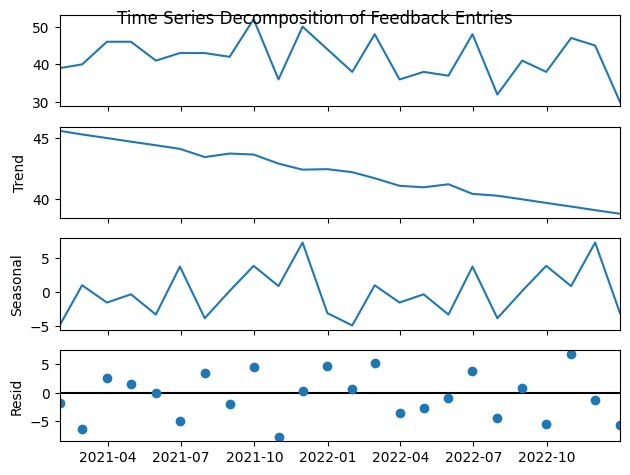

In [27]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Since our time series data is sparse (monthly without many years), we'll assume no frequency
# and perform a naive decomposition
feedback_over_time = df.set_index('date_posted').groupby(pd.Grouper(freq='M')).size()

# Perform seasonal decomposition
decomposition = seasonal_decompose(feedback_over_time, model='additive', extrapolate_trend='freq')

# Plot the decomposed time series components
decomposition_plot = decomposition.plot()

decomposition_plot.suptitle('Time Series Decomposition of Feedback Entries')
plt.show()

### ***Text Analysis (WordCloud)***

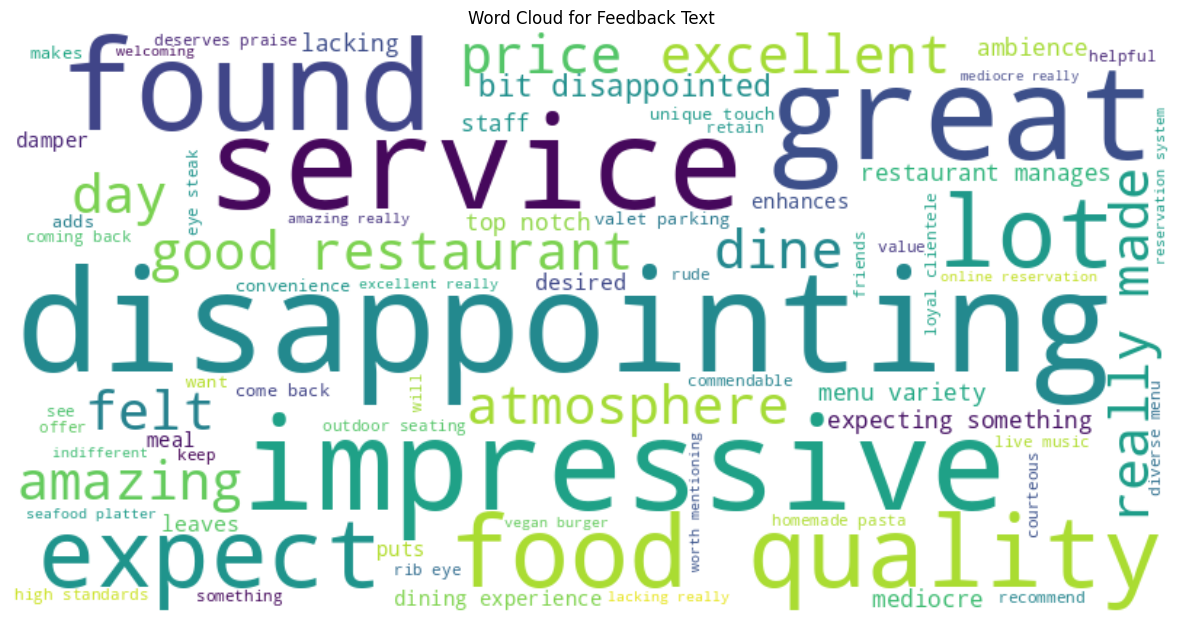

In [28]:
from wordcloud import WordCloud

# Combine all feedback into one text to generate a word cloud
all_feedback_text = " ".join(feedback for feedback in df.feedback)

# Generate a word cloud image
wordcloud = WordCloud(background_color='white', width=800, height=400, max_words=200).generate(all_feedback_text)

# Display the word cloud using matplotlib
plt.figure(figsize=(15, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Turn off axis labels
plt.title('Word Cloud for Feedback Text')
plt.show()

#### **<font color = "black" size = "5">7. Predictive Analytics - Naive Bayes Machine Learning Model </font>**

In [32]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    df['feedback'], df['Sentiment'], test_size=0.2, random_state=42
)

# Create a pipeline that vectorizes the text and then applies a Naive Bayes classifier
model = make_pipeline(CountVectorizer(), MultinomialNB())

# Train the model
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
report = classification_report(y_test, y_pred)

print(report)

              precision    recall  f1-score   support

    NEGATIVE       0.70      0.99      0.82        87
    POSITIVE       0.99      0.68      0.81       113

    accuracy                           0.81       200
   macro avg       0.85      0.83      0.81       200
weighted avg       0.86      0.81      0.81       200

